# Project: Sharktale, SharkTrack

In [ ]:
!pip install xlrd #!pip install country_converter, keep this here pls

### Import of Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Loading the Shark Data

In [ ]:
#define path to xls
url = 'https://www.sharkattackfile.net/spreadsheets/GSAF5.xls'
df = pd.read_excel(url)

## The Data at a Glance:

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.tail()

In [ ]:
df.shape[0]
df.shape[1]

print("Number of Rows: ", df.shape[0])
print("Number of Columns: ", df.shape[1])

df.columns
# Issues w/ og file –> extra 8 columns on VSC? to preserve NaN
# Date, Year, Type, Country, State, Location, Activity, Name, Sex, Age, Injury, Fatal Y/N, Time, Specie, Source
# check search tool between uppercase and lowercase e.g. Australia / AUSTRALIA

In [ ]:
df.describe()

In [ ]:
df.rename(columns= {
    'Fatal Y/N': 'Fatal',
    'Species ': 'Species',
    'pdf': 'PDF', 
    'Sex': 'Gender',
    'href formula': 'Href_formula', 
    'href': 'Href',
    'Case Number': 'Case_Number', 
    'Case Number.1': 'Case_Number_1',
    'original order': 'Original_Order', 
    'Unnamed: 21': 'Unnamed_21', 
    'Unnamed: 22': 'Unnamed_22'
}, inplace=True)
print(df.columns)

In [ ]:
df["Href_formula"].equals(df["Href"]) # Checking if its the same 

In [ ]:
df["Href_formula"].isin(df["Href"]).value_counts() # There is less than 10% difference between the columns. I am keeping Href

In [ ]:
# Dropping Columns
df = df.drop(columns=["Unnamed_21", "PDF", "Unnamed_22", "Href_formula", "Case_Number", "Case_Number_1"])
df.head()

In [ ]:
df.head()

In [ ]:
# Here I am trying to identify the number of unique values for each column and determine which columns appear to be categorical. 
unique_counts = df.nunique() # Identify the number of unique values for each column
print("\nUnique value counts per column: ")
print(unique_counts)

In [ ]:
#Checking for null values in each column 
df.isna().any()

In [ ]:
df.isna().sum()

In [ ]:
df.duplicated().sum()

In [ ]:
df.duplicated().any()

In [ ]:
#Count the number of null values in each column
df.isna().sum()

### Data Cleaning for the Column 'Type' 

In [ ]:
df.Type.unique()

array(['Unprovoked', 'Provoked', ' Provoked', 'Questionable',
       'Watercraft', 'Sea Disaster', nan, '?', 'Unconfirmed',
       'Unverified', 'Invalid', 'Under investigation', 'Boat'],
      dtype=object)

In [ ]:
print(df["Type"].value_counts()) 

In [ ]:
print(df["Type"].value_counts(dropna=False)) # I wanted to review the Nan 

In [ ]:
#df_nan = df[df["Type"].isna()]
#df_nan
#df["Type"] = df["Type"].isnull().sum

In [ ]:
#Reviewing how many were provoked and unprovoked 
print(df["Type"].unique())


In [ ]:
df["Type"] = df["Type"].str.strip()
df["Type"] = df["Type"].replace({
    " Provoked": "Provoked", 
    "Unconfirmed": "Unknown",
    "?" : "Unknown",
    "Invalid": "Unknown",
    "Under investigation": "Unknown",
    "Questionable": "Unknown", 
    "Watercraft" : "Water Vehicle", 
    "Boat" : "Water Vehicle"
})

df["Type"] = df["Type"].fillna("Unknown")
print(df["Type"].unique())

### Data Cleaning for the Column 'Gender'

In [ ]:
df["Gender"] = df["Gender"].replace({
    " M": "M", 
    "M ": "M", 
    "M x 2": "M", 
    " nan": "Unknown", 
    "lli": "Unknown", 
    "N": "M", 
    ".": "Unknown"
    })
df["Gender"] = df["Gender"].fillna("Unknown")
df.Gender.unique()

#### Visualisation: Gender of Victims

In [ ]:
# Piechart to see the distribution between "M", "F". 
df[df["Gender"].isin(["M", "F", "Unknown"])]["Gender"].value_counts().plot(kind="pie", title= "Gender of the Victim", autopct="%1.1f%%", colors=["skyblue", "dodgerblue", "deepskyblue"], table=True)

In [ ]:
country_gender = df.groupby(["Gender", "Country"]).size().to_frame("count").reset_index()
country_gender

### Data Cleaning for the Column 'Species'

In [ ]:
df["Species"].unique()
print(df["Species"].unique()[:600])

In [ ]:
# Cleaning the Column 'Species' a bit 
df["Species"] = df["Species"].str.extract(r'([A-Za-z\s-]+)').fillna("Unknown") # Cleaning here the unnecessary details
df["Species"] = df["Species"].replace({
    "Not stated":"Unknown"
})
print(df["Species"])

In [ ]:
df["Species_Types"] = df["Species"].copy() # creating a copy of species and naming it Species_Types

In [ ]:
df["Species_Types"] = df["Species_Types"].fillna("Unknown").astype(str)

In [ ]:
df["Species_Types"] = df["Species_Types"].replace({
    "Not stated": "Unknown",
    "Not specified": "Unknown",
    "Invalid": "Unknown",
    "Great White Shark": "White Shark"   
}) 

In [ ]:
#Data Cleanining for the Column 'Species'
#df["Species"].unique() df["Species"] = df["Species"]
#df["Species"]
#df.Species.unique()

def clean_shark_name(species): 
    species = species.strip().lower()

    match = re.search(r"(?:\b\w+\s+)*?(great white|horn|white|tiger|bull|Bull|hammerhead|hammer|Hammerhead|blacktip|whale|nurse|mako|reef|Reef)(?:\s+\w+)*?\s*shark(?:\s+\w+)*?", species)
    #match = re.search(r"(great white|white|tiger|bull|hammerhead|blacktip|whale|nurse|mako|reef)s*shark", species)

    if match:
        #return match.group(0).title()
        return match.group(1).title() + " Shark"
    else: 
        return "Other/Unknown"

df["Species_Types"] = df["Species_Types"].apply(clean_shark_name)

print(df["Species_Types"].value_counts())  # Check unique values
print(df["Species_Types"].tail())  # Display first few rows
#print(df_Species.nunique()) 
#print(df_Species.unique()[:100])

In [ ]:
#df.dtypes
df["Species_Types"].value_counts()

In [ ]:
df["Species_Types"] = df["Species_Types"].str.strip()

In [ ]:
print(df["Species_Types"].value_counts())

#### Visualisation for Species Types

In [ ]:
species_types_group = df.groupby("Species_Types")
shark_attack_by_species_types = species_types_group["Species_Types"].count()
shark_attack_by_species_types = shark_attack_by_species_types.sort_values(ascending=False)
top_species_types_attack = shark_attack_by_species_types.head(15)
top_species_types_attack

In [ ]:
plt.figure(figsize=(15,2))
sns.barplot(x=top_species_types_attack.index, y=top_species_types_attack, color="skyblue")
plt.title("Number of Attacks by Species Types")
plt.ylabel("Number of Attacks")
plt.show()

In [ ]:
# This can be ignored, but can be usable for in the future
#Group_Species = df.groupby("Species")

#for species, group in Group_Species:
#    print(f"Group name: {species}")
#   # display(group)
#df["Species"].nunique() == len(Grouped_Species)

In [ ]:
#df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

### Data Cleaning for the 'Country' Column

In [ ]:
df["Country"].unique()

In [ ]:
len(df["Country"].unique())

In [ ]:
update_country = {
    'AUSTRALIA': 'Australia',
    'BAHAMAS': 'Bahamas',
    'BELIZE': 'Belize',
    'COLOMBIA': 'Colombia',
    'COLUMBIA': 'Colombia',
    'EGYPT': 'Egypt',
    'ENGLAND': 'United Kingdom',
    'FRENCH POLYNESIA': 'French Polynesia',
    'INDIA': 'India',
    'INDONESIA': 'Indonesia',
    'JAMAICA': 'Jamaica',
    'JAPAN': 'Japan',
    'MALDIVE ISLANDS': 'Maldives',
    'MALDIVES': 'Maldives',
    'MEXICO': 'Mexico',
    'MeXICO': 'Mexico',
    'MEXICO ': 'Mexico',
    'NEW CALEDONIA': 'New Caledonia',
    'NEW ZEALAND': 'New Zealand',
    'PHILIPPINES': 'Philippines',
    'SPAIN': 'Spain',
    'SOUTH AFRICA': 'South Africa',
    'South Africa': 'South Africa',
    'THAILAND': 'Thailand',
    'TRINIDAD': 'Trinidad and Tobago',
    'TRINIDAD & TOBAGO': 'Trinidad and Tobago',
    'TURKS & CAICOS': 'Turks and Caicos',
    'TURKS and CaICOS': 'Turks and Caicos',
    'UNITED ARAB EMIRATES (UAE)': 'United Arab Emirates',
    'UNITED KINGDOM': 'United Kingdom',
    'USA': 'United States',
    'UAE': 'United Arab Emirates',
    'UNITED STATES': 'United States',
    'REUNION ISLAND': 'Reunion',
    'REUNION': 'Reunion',
    'ST MARTIN': 'Saint Martin',
    'ST. MARTIN': 'Saint Martin',
    'ST. MAARTIN': 'Saint Martin',
    'SAINT MAARTEN': 'Saint Martin',
    'PAPUA NEW GUINEA': 'Papua New Guinea',
    'FIJI': 'Fiji',
    'Fiji': 'Fiji',
    'CANADA': 'Canada',
    'CUBA': 'Cuba',
    'ARGENTINA': 'Argentina',
    'BRAZIL': 'Brazil',
    'CHILE': 'Chile',
    'ECUADOR': 'Ecuador',
    'PERU': 'Peru',
    'VENEZUELA': 'Venezuela',
    'COOK ISLANDS': 'Cook Islands',
    'DOMINICAN REPUBLIC': 'Dominican Republic',
    'SEYCHELLES': 'Seychelles',
    'ST KITTS / NEVIS': 'Saint Kitts and Nevis',
    'ST HELENA, British overseas territory': 'Saint Helena',
    'SOLOMON ISLANDS': 'Solomon Islands',
    'TONGA': 'Tonga',
    ' TONGA': 'Tonga',
    'KIRIBATI': 'Kiribati',
    'PALAU': 'Palau',
    'MALTA': 'Malta',
    'SCOTLAND': 'United Kingdom',
    'IRELAND': 'Ireland',
    'ITALY': 'Italy',
    'MALAYSIA': 'Malaysia',
    'LIBYA': 'Libya',
    'JORDAN': 'Jordan',
    'ISRAEL': 'Israel',
    'CHINA': 'China',
    'TAIWAN': 'Taiwan',
    'INDIAN OCEAN': 'Indian Ocean',
    'INDIAN OCEAN?': 'Indian Ocean',
    'INDIAN OCEAN?': 'Indian Ocean',
    'NORTH ATLANTIC OCEAN': 'North Atlantic Ocean',
    'NORTH ATLANTIC OCEAN ': 'North Atlantic Ocean',
    'SOUTH ATLANTIC OCEAN': 'South Atlantic Ocean',
    'ATLANTIC OCEAN': 'Atlantic Ocean',
    'PACIFIC OCEAN': 'Pacific Ocean',
    'PACIFIC OCEAN ': 'Pacific Ocean',
    'SOUTH PACIFIC OCEAN': 'South Pacific Ocean',
    'NORTH PACIFIC OCEAN': 'North Pacific Ocean',
    'CARIBBEAN SEA': 'Caribbean Sea',
    'MID ATLANTIC OCEAN': 'Mid Atlantic Ocean',
    'SOUTH CHINA SEA': 'South China Sea',
    'BAY OF BENGAL': 'Bay of Bengal',
    'RED SEA': 'Red Sea',
    'RED SEA?': 'Red Sea',
    'RED SEA / INDIAN OCEAN': 'Red Sea',
    'GULF OF ADEN': 'Gulf of Aden',
    'PERSIAN GULF': 'Persian Gulf',
    'CEYLON': 'Sri Lanka',
    'CEYLON (SRI LANKA)': 'Sri Lanka',
    'SRI LANKA': 'Sri Lanka',
    'BANGLADESH': 'Bangladesh',
    'BURMA': 'Myanmar',
    'MYANMAR': 'Myanmar',
    'VIETNAM': 'Vietnam',
    'HONG KONG': 'Hong Kong',
    'MARTINIQUE': 'Martinique',
    'NETHERLANDS ANTILLES': 'Netherlands Antilles',
    'NORTHERN MARIANA ISLANDS': 'Northern Mariana Islands',
    'FEDERATED STATES OF MICRONESIA': 'Micronesia',
    'MICRONESIA': 'Micronesia',
    'FALKLAND ISLANDS': 'Falkland Islands',
    'GIBRALTAR': 'Gibraltar',
    'SAUDI ARABIA': 'Saudi Arabia',
    'SINGAPORE': 'Singapore',
    'SENEGAL': 'Senegal',
    'SOMALIA': 'Somalia',
    'SOUTH KOREA': 'South Korea',
    'NORTH KOREA': 'North Korea',
    'RUSSIA': 'Russia',
    'GREECE': 'Greece',
    'TUNISIA': 'Tunisia',
    'TURKEY': 'Turkey',
    'IRAN': 'Iran',
    'IRAQ': 'Iraq',
    'KUWAIT': 'Kuwait',
    'LEBANON': 'Lebanon',
    'SYRIA': 'Syria',
    'AFRICA': 'Africa',
    'Coast of AFRICA': 'Africa',
    'GEORGIA': 'Georgia',
    'GHANA': 'Ghana',
    'GUINEA': 'Guinea',
    'NAMIBIA': 'Namibia',
    'TANZANIA': 'Tanzania',
    'ALGERIA': 'Algeria',
    'DJIBOUTI': 'Djibouti',
    'EQUATORIAL GUINEA / CAMEROON': 'Equatorial Guinea',
    'WEST INDIES': 'Caribbean',
    'BRITISH ISLES': 'United Kingdom',
    'BRITISH WEST INDIES': 'Caribbean',
    'ST HELENA, British overseas territory': 'Saint Helena',
    'NORWAY': 'Norway',
    'ICELAND': 'Iceland',
    'GABON': 'Gabon',
    'MAYOTTE': 'Mayotte',
    'SWEDEN': 'Sweden',
    'SLOVENIA': 'Slovenia',
    'CURACAO': 'Curaçao',
    'HAITI': 'Haiti',
    'GUATEMALA': 'Guatemala',
    'NICARAGUA': 'Nicaragua',
    'NICARAGUA ': 'Nicaragua',
    'HONDURAS': 'Honduras',
    'EL SALVADOR': 'El Salvador',
    'COSTA RICA': 'Costa Rica',
    'PANAMA': 'Panama',
    'BARBADOS': 'Barbados',
    'ARUBA': 'Aruba',
    'GRAND CAYMAN': 'Cayman Islands',
    'CAYMAN ISLANDS': 'Cayman Islands',
    'SAINT LUCIA': 'Saint Lucia',
    'USA': 'United States', 
    'Usa': 'United States'
}

In [ ]:
df['Country'] = df['Country'].replace(update_country).fillna('Unknown')

In [ ]:
df['Country'].unique()

In [ ]:
 #Data Cleaning for the column 'Country', I've tried to use regex 
df["Country"] = df["Country"].str.strip().str.title()
df["Country"] = df["Country"].str.replace(r"[^a-zA-Z\s]", "", regex=True)
#df["Country"] = df["Country"].map(lambda x: x.upper())
df["Country"] = df["Country"].fillna("Unknown")
print(df["Country"].unique())

In [ ]:
unique_country = len(df['Country'].unique())
unique_country

In [ ]:
df["Country"] = df["Country"].replace(update_country) # Reassigning it back to "Country"

In [ ]:
country_group = df.groupby('Country')
number_of_attacks = country_group['Country'].count()
number_of_attacks = number_of_attacks.sort_values(ascending=False)
top_10_attacks = number_of_attacks.head(10)
top_10_attacks

#### Visualisation, Top 10 Countries of Number of Shark Attacks

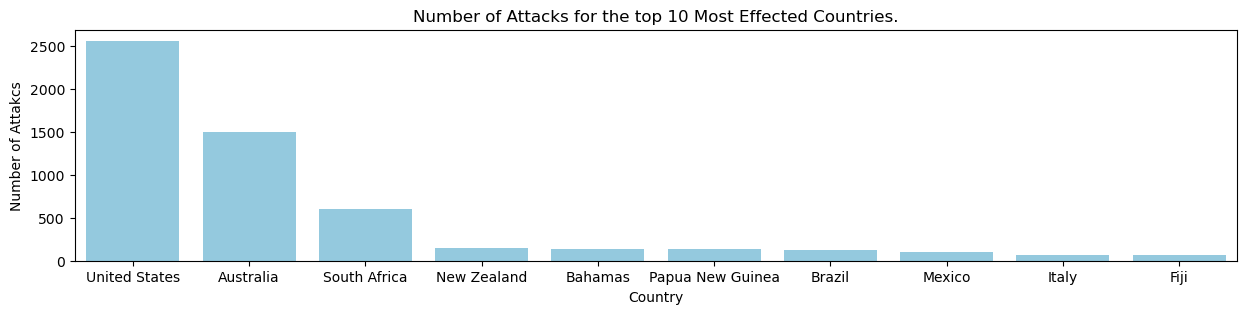

In [101]:
plt.figure(figsize=(15,3))
sns.barplot(x=top_10_attacks.index, y=top_10_attacks, color="skyblue")
plt.title("Number of Attacks for the top 10 Most Effected Countries.")
plt.ylabel("Number of Attakcs")
plt.show()

#### Top 10 Areas in The USA with Shark Attacks 

In [103]:
USA_attacks = df[df.Country == "United States"].groupby("Area")["Area"].count().sort_values(ascending=False)[:10]

KeyError: 'Area'

#### Visualisation: Gender Distribution of Victims of Shark Attacks.

In [ ]:
#df["Gender"] = df["Gender"].fillna("Unknown")  # Replace NaN with "Unknown"

gender_group = df.groupby("Gender")
gender_country_group = gender_group["Country"].count()
gender_of_injured = gender_country_group.sort_values(ascending=False)
gender_of_injured.index = gender_of_injured.index.map({"M": "Male", "F": "Female"}).fillna("Unknown")  # Map known values and keep "Unknown"

plt.figure(figsize=(8, 8))
plt.pie(gender_of_injured, labels=gender_of_injured.index, autopct="%1.1f%%", startangle=90, colors=["skyblue", "dodgerblue", "deepskyblue"])
plt.title("Gender Distribution in the Injured")
plt.show()

### Data Cleaning for the Column 'Location'

In [ ]:
# Cleaning for location
df["Location"] = df["Location"].astype(str)
df["Location"] = df["Location"].map(lambda x:x.upper())
df["Location"] = df["Location"].fillna("Unknown")
df["Location"] = df["Location"].str.strip()
df["Location"] = df["Location"].replace({
    "NAN": "Unknown",
     "nan": "Unknown",
      "Nan": "Unknown", 
})
df["Location"] 

### Visualisation for 'Location'

In [ ]:
# Data Cleaning for the Column 'State'
#df["State"] = df["State"].
df["State"] = df["State"].fillna("Unknown")
df["State"] = df["State"].astype(str)
df["State"] = df["State"].str.strip()
df["State"] = df["State"].replace({
    "NAN": "Unknown",
    "nan": "Unknown",
    "Nan": "Unknown", 
    " ": "Unknown",
    "  ": "Unknown"
})
print(df["State"].unique())

In [ ]:
# Data Cleaning for the Column Activity 
df["Activity"] = df["Activity"].fillna("Unknown")
df["Activity"] = df["Activity"].astype(str)
df["Activity"] = df["Activity"].str.strip()
df["Activity"] = df["Activity"].replace({
    "NAN": "Unknown",
     "nan": "Unknown",
      "Nan": "Unknown",
})
# Needs more cleaning 

### Data Cleaning for the Column 'Activity'

In [ ]:
df["Activity"].describe()

In [ ]:
df['Activity'].unique()[:100]

In [ ]:
len(df['Activity'].unique())

In [ ]:
# Data Cleaning for the Column 'Name' 
df["Activity"] = df["Activity"].fillna("Unknown")
df["Activity"] = df["Activity"].astype(str)
df["Activity"] = df["Activity"].str.strip()
df["Activity"] = df["Activity"].replace({
    "NAN": "Unknown",
     "nan": "Unknown",
      "Nan": "Unknown"
})
df["Activity"]
# Needs to be furthered cleaned 

In [ ]:
def clean_activity(activity): 
    if not isinstance(activity, str):  # Handle NaN values
        return "Other/Unknown"
    
    activity = activity.strip().lower()  # Normalize text
    
    pattern = r"(?:\b\w+\s+)*?\b(surfing|swimming|fishing|kite|paddle(?:boarding)?|snorkeling|Shark|diving|kayaking|bathing|bodyboarding|spearfishing|boogie boarding|wading|floating|scuba diving|free diving|wakeboarding|windsurfing|sailing|jet skiing|canoeing|rafting|water skiing)(?:\s+\w+)*?\b"
    
    match = re.search(pattern, activity, re.IGNORECASE)  # Applying regex
    
    if match:
        return match.group(1).title()  # Capitalize the matched activity
    else: 
        return "Other/Unknown"

# Apply function to the dataframe
df['Cleaned_Activity'] = df['Activity'].apply(clean_activity)

# Check the results
print(df["Cleaned_Activity"].value_counts())  # Count occurrences of each category
print(df["Cleaned_Activity"].tail())  # Displaying last few rows

In [ ]:
df['Cleaned_Activity'].unique()[:100]

In [ ]:
df["Cleaned_Activity"] = df["Cleaned_Activity"].replace({"Kite": "Kite Surfing", "Shark": "Activity with Shark"})

In [ ]:
df["Cleaned_Activity"].value_counts()

### Data Cleaning for the Column 'Age'

In [ ]:
# Data Cleaning for the Column Age
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df["Age"].describe()

In [ ]:
df["Age"].describe()

In [ ]:
# Since the Mean is 28.104841, I am going to replace it with all the null values, without greatily altering the distribution of the "Age" Column. 
df["Age"] = df["Age"].fillna(28.104841)
df["Age"]

#### Visualtisation for Data & Age

In [ ]:
df.plot(kind='scatter', x='Age', y='Cleaned_Activity', figsize=(6,6))

In [ ]:
# I am graphicing here the Data & Age
fix, ax = plt.subplots(figsize=(8,6))
ax = sns.distplot(df["Age"],
ax = ax, 
hist_kws = {"alpha": 0.6, "color": "#517AE9"}, 
kde=False, bins=20)
plt.xlabel("Age of the Victim in Years")
plt.ylabel("Count")
plt.title("Age Distribution")

In [ ]:
#sns.pairplot(df)
#plt.suptitle("Relationships between Age, Year and Original Order")

### Fatal Rate of Shark Attacks 

In [ ]:
df["Fatal"].unique()

In [ ]:
df["Fatal"] = df["Fatal"].fillna("Unknown").str.strip().astype(str)

In [ ]:
# Data Cleaning for The Column Fatal
df["Fatal"] = df["Fatal"].fillna("Unknown")
df["Fatal"] = df["Fatal"].str.strip()
df["Fatal"].value_counts(dropna=False)
df["Fatal"] = df["Fatal"].astype(str)
df["Fatal"] = df["Fatal"].replace({
    "Nan": "Unknown",
    " N": "NO",
    "UNKNOWN": "Unknown",
    "F": "Unknown",\
    "M": "NO",
    "n": "NO",
    "N": "NO",
    "Nq": "NO",
    "Y": "YES",
    2017: "Unknown",
    "2017 ": "Unknown",
     "Y x 2": "Yes",
     "y": "Yes",
     "N   ": "NO",
})
#df["Fatal"] = df["Fatal"]
#df["Fatal"] = df["Fatal"]
#df["Fatal"] = df["Fatal"]
df["Fatal"].unique()

In [ ]:
gender_grp = df.groupby("Fatal")
gender_grp.count()

#### Visualisation: Fatal Rate of Shark Attacks 

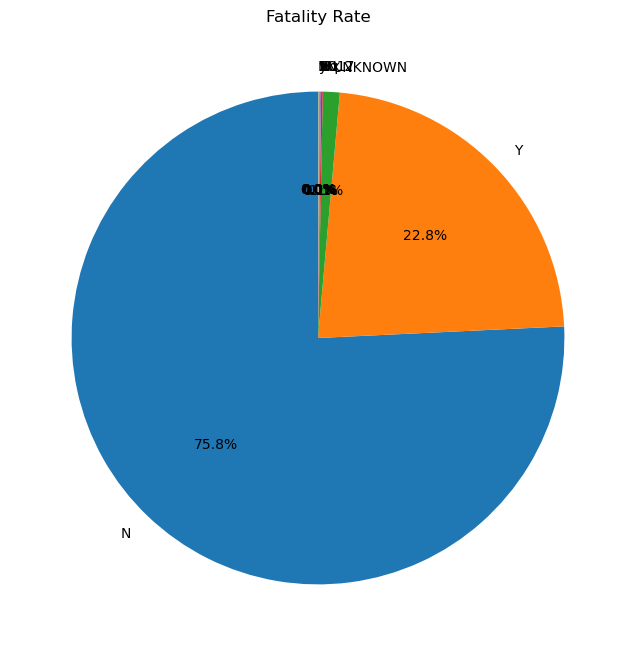

In [107]:
# Plot Pie Chart Column and COunt of Occurrences 

# Grouping by Fatal Column and Count Occurrences 
fatal_counts = df["Fatal"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(fatal_counts, labels=fatal_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Fatality Rate")
plt.show()

#### Fatality Rate by Gender

In [ ]:
# Group by gender and Fatality Rate
gender_fatal_counts = df.groupby(["Gender", "Fatal"]).size().unstack()

# Plot Stacked Bar Chart
gender_fatal_counts.plot(kind="bar", stacked=True, figsize=(4, 5))

plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Fatality Rate by Gender")
plt.legend(title="Fatality", labels=gender_fatal_counts.columns)
plt.xticks(rotation=0)
plt.show()

In [ ]:
df_count = df.groupby("Year")["Date"].count()
df_count

### Data Cleaning for the Column 'Date'

In [ ]:
df["Date"].value_counts()

#### Visualisation for Date

In [ ]:
df_count = df.groupby("Year")["Date"].count()
df_count[df_count.index > 1750].plot()

In [ ]:
df_count#.isna().sum()

In [ ]:
df_usa = df[df["Country"] == "USA"]
df_usa

In [ ]:
#df_count = df.groupby("Country")["Year"].count()
#df_count[df_count.index > 1750].plot()

In [ ]:
#df["Date"] = pd.to_datetime(df["Date"]) # Converting Object to dfate 
set(df["Date"].sample(n=50))

In [ ]:
len(set(df["Date"])) # Too Many Values To go One by One.

In [ ]:
#df_usa["Date"].value_counts()

In [ ]:
#pd.to_datetime(df_usa["Data_Clean"])